<h1> Model 2: Decision Tree </h1>

<h2> Import the packages/classes and load the data </h2>

In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV, StratifiedKFold, cross_val_predict, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import change_summary
changelog = pd.read_csv('../Changelogs/change_summary.csv').to_dict(orient='records')

# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

,column,change,rationale
0,age,Removed 3 row(s) where age > 125,Oldest verified human lived to be 122; values above 125 are likely errors or outliers.
1,loan_status,Dropped loan_status column,Target variable for classification; not needed in cleaned dataset.
2,person_income,"Capped person_income at $3,000,000 and applied log1p transformation",Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.
3,loan_amnt,Applied log1p transformation to loan_amount,Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.
4,person_emp_exp,Removed 5 row(s) where person_emp_exp > 70,Unrealistic employment experience; values above 70 years are likely errors or outliers.
5,person_education,Combined Master and Doctorate categories into one group -- Graduate,Doctorate had the lowest frequency out of all the categories which could impact analysis
6,person_home_ownership,Combined RENT and OTHER into Non-Homeowner category and MORTGAGE and OWN into Homeowner category,RENT and MORTGAGE had high frequencies while OWN and OTHER had low frequencies which could impact analysis
7,"['person_gender', 'loan_intent', 'previous_loan_defaults_on_file', 'person_education_new', 'person_home_ownership_new']",Applied one-hot encoding (drop_first=True),Converted categorical variables into binary indicators for model compatibility.
8,loan_status,Readded loan_status column,Target variable for classification; readded after cleaning and preprocessing.


In [4]:
# Load cleaned data from CSV
df = pd.read_csv("../Data/cleaned_loan_data.csv")
df.head()

,person_age,person_emp_exp,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,log_income,log_loan_amt,person_gender_male,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes,person_education_new_Bachelor,person_education_new_Graduate,person_education_new_High School,person_home_ownership_new_Non-Homeowner,loan_status
0,22,0,16.02,0.49,3,561,11.183713,10.463132,0,0,0,0,1,0,0,0,1,0,1,1
1,21,0,11.14,0.08,2,504,9.415971,6.908755,0,1,0,0,0,0,1,0,0,1,0,0
2,25,3,12.87,0.44,3,635,9.428592,8.612685,0,0,0,1,0,0,0,0,0,1,0,1
3,23,0,15.23,0.44,2,675,11.286702,10.463132,0,0,0,1,0,0,0,1,0,0,1,1
4,24,1,14.27,0.53,4,586,11.099469,10.463132,1,0,0,1,0,0,0,0,1,0,1,1


<h2> Data Prep </h2>

In [5]:
# Split the data into features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [6]:
#Split the data into the draining and test sets 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (31494, 19)
X_test: (13498, 19)


In [8]:
# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Check for class imbalance
print(f"Class distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in test set:\n{y_test.value_counts(normalize=True)}")

# Changelog addition
changelog.append({
    'column': 'numerical_columns',
    'change': 'Applied MinMaxScaler to training data; transformed test data using same scaler.',
    'rationale': 'Avoided data leakage by fitting scaler only on training data. Ensures proper model generalization and adheres to machine learning best practices.'
})


Class distribution in training set:
loan_status
0    0.777799
1    0.222201
Name: proportion, dtype: float64
Class distribution in test set:
loan_status
0    0.777819
1    0.222181
Name: proportion, dtype: float64


<h2> Build the Model </h2>


<h3> Base Model </h3>

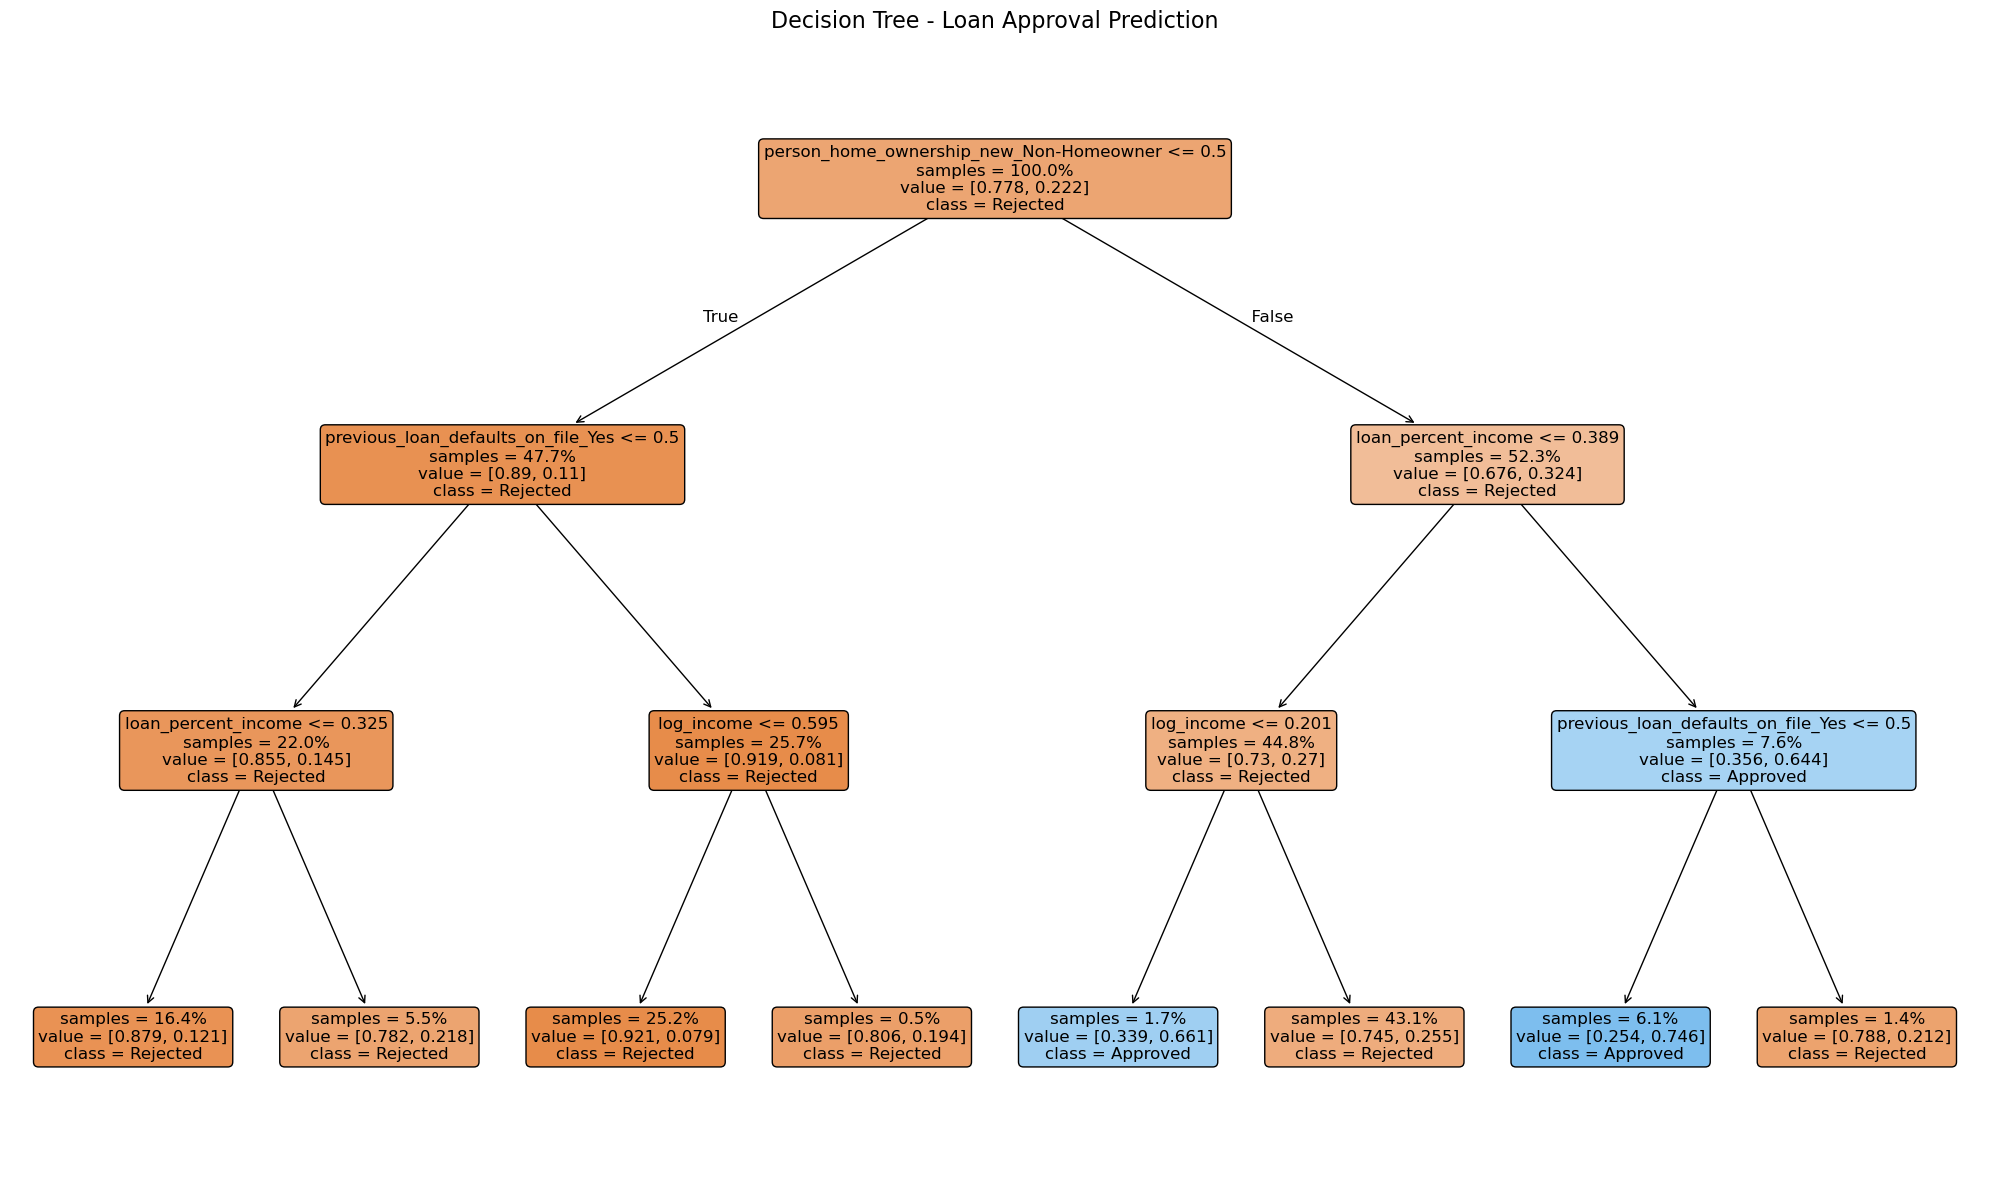

In [9]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=3,random_state=42)
dt_model.fit(X_train_scaled, y_train)


# Visualize the Decision Tree
plt.figure(figsize=(20, 12))  
plot_tree(dt_model,
          filled=True,
          rounded=True,
          feature_names=X_train.columns,
          class_names=['Rejected', 'Approved'],
          fontsize=12,
          impurity=False,       
          proportion=True)      
plt.title("Decision Tree - Loan Approval Prediction", fontsize=16)
plt.tight_layout()
plt.show()



--- DT Model Evaluation ---

Decision Tree:
              precision    recall  f1-score   support

    Rejected       0.82      0.97      0.89     10499
    Approved       0.74      0.27      0.39      2999

    accuracy                           0.82     13498
   macro avg       0.78      0.62      0.64     13498
weighted avg       0.81      0.82      0.78     13498



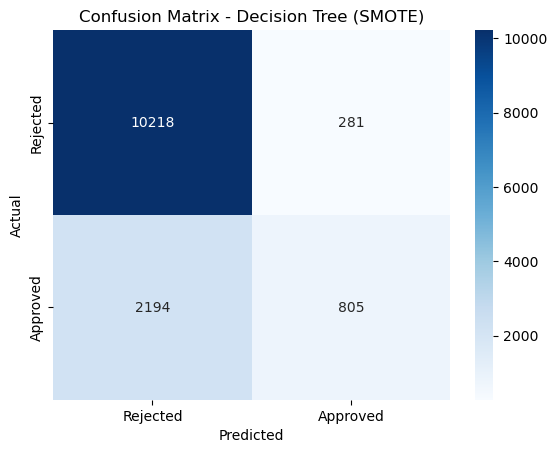

Accuracy Score:  0.8166395021484665
Precision Score:  0.7412523020257827
Recall Score:  0.2684228076025342
F1 Score:  0.39412484700122397
Specificity Score:  0.9732355462424993


In [11]:
#SMOTE Decision Tree Evaluation
print("\n--- DT Model Evaluation ---")

# Decision Tree
dt_predictions = dt_model.predict(X_test_scaled)
print("\nDecision Tree:")
print(classification_report(y_test, dt_predictions, target_names=['Rejected', 'Approved']))

cm_dt = confusion_matrix(y_test, dt_predictions)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree (SMOTE)')
plt.show()

# Model Scores
print('Accuracy Score: ', accuracy_score(y_test, dt_predictions))
print('Precision Score: ', precision_score(y_test, dt_predictions))
print('Recall Score: ', recall_score(y_test, dt_predictions))
print('F1 Score: ', f1_score(y_test, dt_predictions))

tn = cm_dt[0,0]
fp = cm_dt[0,1]
specificity = tn/(tn+fp)
print('Specificity Score: ', specificity)

**Most loan applications are rejected**
Based on the decision tree above, approval is mainly given to a small portion of non-homeowners who have high income and no previous loan defaults. For homeowners, even if they don't have prior defaults, the likelihood of rejection remains high, especially if their loan amount is large relative to their income or their income is not very high. Overall, previous loan defaults, loan burden (loan_percent_income), and income level are the strongest factors influencing the final decision, with clean credit history and strong income being critical for approval.

The Decision Tree model demonstrates strong performance in predicting the "Rejected" class, with a precision of 0.82 and an exceptionally high recall of 0.97, leading to a solid f1-score of 0.89. This indicates that the model is very good at correctly identifying rejected loan applications. However, its performance on the "Approved" class is much weaker, with a precision of 0.74 but a low recall of 0.27 and an f1-score of only 0.39. This shows that the model struggles to correctly identify approved loans, often misclassifying them as rejections. Although the overall accuracy is 82%, it is heavily biased toward the majority "Rejected" class. The macro averages, particularly a recall of 0.62 and an f1-score of 0.64, highlight this imbalance, suggesting the model is not equally effective for both classes.

<h3> Apply Smote to the data and re-run the model</h3>

In [28]:
# SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_smote_train, y_smote_train = smote.fit_resample(X_train_scaled, y_train)

# Check the class distribution after SMOTE
X_smote_test = X_test_scaled
y_smote_test = y_test

# Changelog entry for SMOTE
changelog.append({
    'column': 'subscribe_to_term_deposit',
    'change': f'Resampled training set with SMOTE (train shape now: {X_smote_train.shape}, test shape: {X_test.shape})',
    'rationale': 'Used SMOTE to correct class imbalance in training data for better model performance.'
})


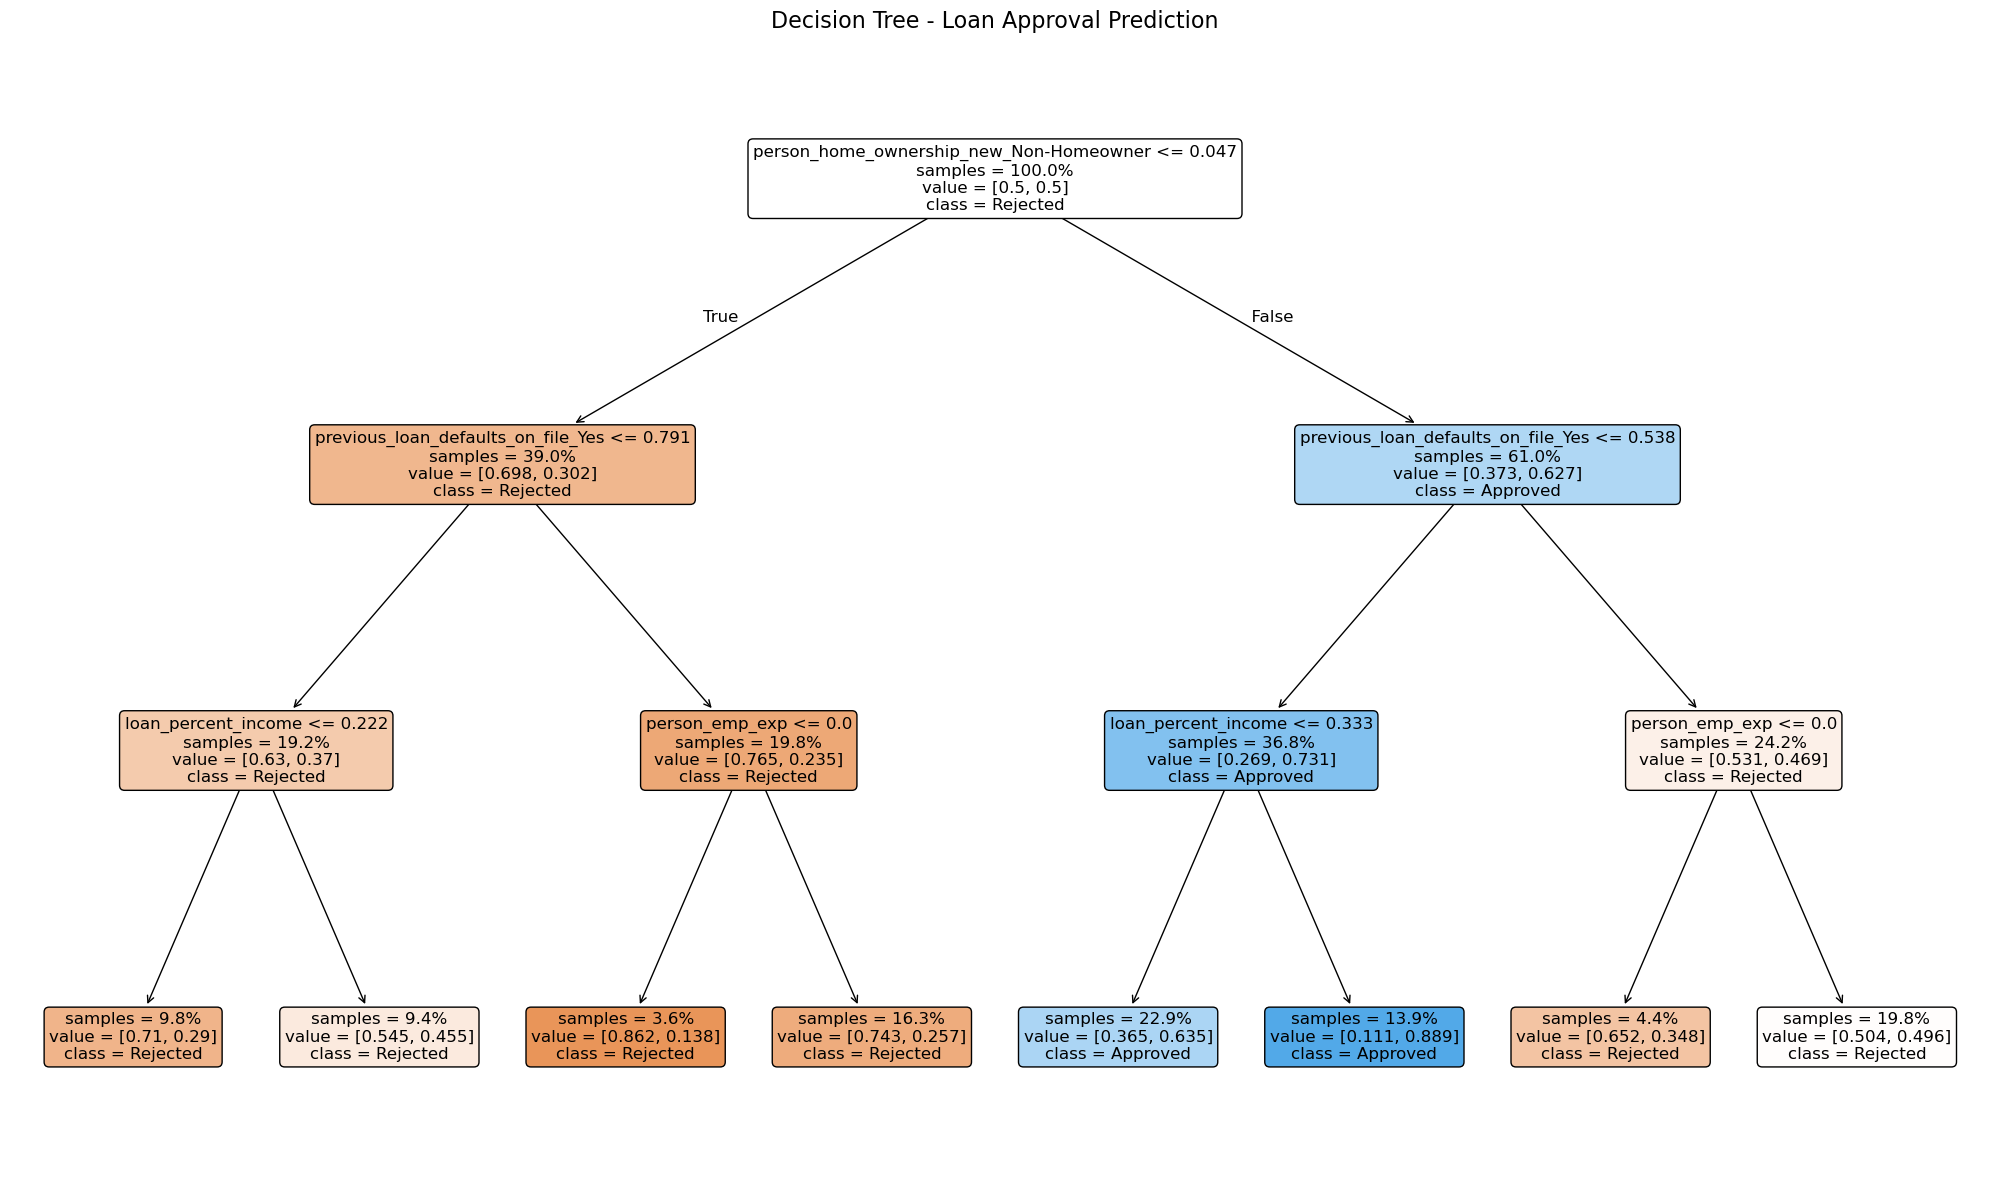

In [ ]:

# Initialize the Decision Tree
smote_dt_model = DecisionTreeClassifier(max_depth=3,random_state=42)
smote_dt_model.fit(X_smote_train, y_smote_train)

# Visualize the Decision Tree
plt.figure(figsize=(20, 12))  
plot_tree(smote_dt_model,
          filled=True,
          rounded=True,
          feature_names=X_train.columns,
          class_names=['Rejected', 'Approved'],
          fontsize=12,
          impurity=False,       
          proportion=True)      
plt.title("Decision Tree - Loan Approval Prediction", fontsize=16)
plt.tight_layout()
plt.show()

In the first decision tree (without SMOTE), the model is clearly biased towards rejecting applications, with most splits heavily favoring the "Rejected" class. Only a very small portion of the tree is dedicated to approving loans. This indicates that the model was trained on an imbalanced dataset where loan rejections were far more frequent than approvals, leading to a decision tree that struggles to identify the minority class (approved loans). In contrast, this second decision tree model (with SMOTE) shows a more balanced structure. There are more branches that lead to "Approved" decisions, and the value distributions in nodes are closer to being balanced between approval and rejection. This demonstrates that applying SMOTE helped the decision tree better learn patterns for both classes, leading to improved classification of approved loans and reducing the model’s bias towards rejection.


--- SMOTE DT Model Evaluation ---

Decision Tree:
              precision    recall  f1-score   support

    Rejected       0.86      0.80      0.83     10499
    Approved       0.44      0.54      0.49      2999

    accuracy                           0.74     13498
   macro avg       0.65      0.67      0.66     13498
weighted avg       0.77      0.74      0.75     13498



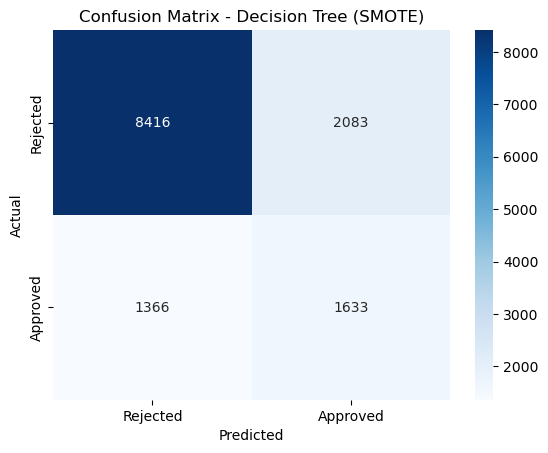

Accuracy Score:  0.7444806638020447
Precision Score:  0.43945102260495156
Recall Score:  0.5445148382794265
F1 Score:  0.48637379002233805
Specificity Score:  0.8016001523954662


In [30]:
# SMOTE Decision Tree Evaluation
print("\n--- SMOTE DT Model Evaluation ---")

# Decision Tree
smote_dt_predictions = smote_dt_model.predict(X_smote_test)
print("\nDecision Tree:")
print(classification_report(y_smote_test, smote_dt_predictions, target_names=['Rejected', 'Approved']))

smote_cm_dt = confusion_matrix(y_smote_test, smote_dt_predictions)
sns.heatmap(smote_cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree (SMOTE)')
plt.show()

# Model Scores
print('Accuracy Score: ', accuracy_score(y_test, smote_dt_predictions))
print('Precision Score: ', precision_score(y_test, smote_dt_predictions))
print('Recall Score: ', recall_score(y_test, smote_dt_predictions))
print('F1 Score: ', f1_score(y_test, smote_dt_predictions))

tn_smote = smote_cm_dt[0,0]
fp_smote = smote_cm_dt[0,1]
specificity_smote = tn_smote/(tn_smote+fp_smote)
print('Specificity Score: ', specificity_smote)

The Decision Tree model trained after applying SMOTE shows a significant improvement in identifying Approved loan applications, increasing recall from 0.27 to 0.54 — meaning the model now correctly captures more than half of the actual approvals. The f1-score for the Approved class also improved from 0.39 to 0.49, indicating a more balanced trade-off between precision and recall. However, this gain comes at the cost of overall accuracy, which dropped from 82% to 74%, and a lower recall for the Rejected class (0.97 → 0.80), meaning the model now misclassifies more rejections as approvals.

<h3> Model with Cross Validation </h3>

In [31]:
# Cross-validation for Decision Tree
dt_cv_scores = cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=42),
                                X_train_scaled, y_train, cv=5, scoring='f1')

#Cross-validation for Decision Tree with smote
dt_cv_smote_scores = cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=42),
                                X_smote_train, y_smote_train, cv=5, scoring='f1')

print("Decision Tree Cross-Validation Comparison:")
print(f"{'Dataset':<20}{'Mean CV F1 Score':<20}")
print(f"{'Original':<20}{dt_cv_scores.mean():<20.4f}")
print(f"{'SMOTE':<20}{dt_cv_smote_scores.mean():<20.4f}")


Decision Tree Cross-Validation Comparison:
Dataset             Mean CV F1 Score    
Original            0.3775              
SMOTE               0.6486              


In [32]:
#Create the model
dt_CV = DecisionTreeClassifier(max_depth=3, random_state=42)

#Set the number of splits
k_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Create pipeline to scale and run the model
pipeline = Pipeline([('scaler', scaler), ('model',dt_CV)])

#Run the cross-validation and evaluate the model
cv_scores = cross_val_score(pipeline, X, y, cv=k_folds, scoring='f1')
print("Cross-validation scores:", cv_scores)
print("Mean CV F1 Score:", cv_scores.mean())

Cross-validation scores: [0.38504258 0.37343173 0.37308411 0.40390173 0.3765227 ]
Mean CV F1 Score: 0.3823965718996837


In [33]:
#Create the model
dt_CV_smote = DecisionTreeClassifier(max_depth=3, random_state=42)

#Set the number of splits
k_folds_smote = KFold(n_splits=5, shuffle=True, random_state=42)

#Create pipeline to scale and run the model
pipeline_smote = ImbPipeline([('scaler', scaler), ('smote', smote), ('model',dt_CV_smote)])

#Run the cross-validation and evaluate the model
cv_scores_smote = cross_val_score(pipeline_smote, X, y, cv=k_folds_smote, scoring='f1')
print("Cross-validation scores:", cv_scores_smote)
print("Mean CV F1 Score:", cv_scores_smote.mean())

Cross-validation scores: [0.48410098 0.45687869 0.47619048 0.47465527 0.44715689]
Mean CV F1 Score: 0.46779646205467457


The Original dataset (without SMOTE) has a mean CV F1 score of 0.3824, which is quite low. This confirms that, although accuracy looked good earlier, the model performs poorly at balancing precision and recall — especially for the minority class (Approved). After applying SMOTE, the mean F1 score jumps to 0.4678, showing a substantial improvement in class balance and overall predictive quality — especially for the minority class.

<h3> Hyperparameter Tuning </h3>

<h4> Original Data </h4>

In [34]:
print("\n--- Hyperparameter Tuning using Grid Search CV ---")

# Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 15),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 4, 5]
}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                               param_grid=dt_param_grid, cv=5, scoring='f1', n_jobs=-1)
dt_grid_search.fit(X_train_scaled, y_train)

print("\nDecision Tree Best Parameters:", dt_grid_search.best_params_)
dt_best_model = dt_grid_search.best_estimator_


--- Hyperparameter Tuning using Grid Search CV ---


/Applications/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Decision Tree Best Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 10}



Logistic Regression (Tuned):
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     10499
           1       0.67      0.31      0.43      2999

    accuracy                           0.81     13498
   macro avg       0.75      0.64      0.66     13498
weighted avg       0.80      0.81      0.79     13498



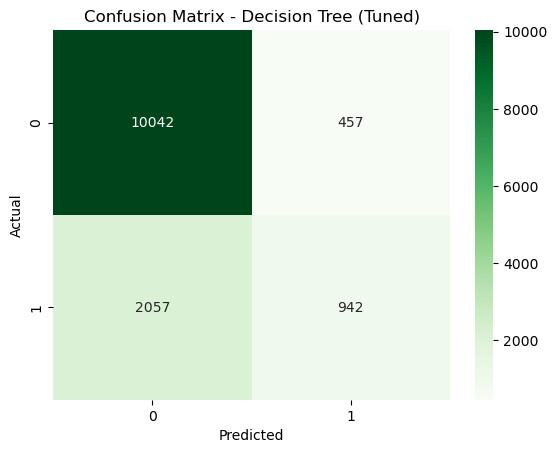

Accuracy Score:  0.8137501852126241
Precision Score:  0.6733380986418871
Recall Score:  0.31410470156718906
F1 Score:  0.42837653478854026
Specificity Score:  0.9564720449566625


In [ ]:
# Define string labels for display
target_names = ['0', '1'] 

# Generate predictions
lr_tuned_predictions = dt_best_model.predict(X_test_scaled)

# Classification report
print("\nDecision Tree (Tuned):")
print(classification_report(y_test, lr_tuned_predictions, target_names=target_names))

# Confusion matrix
cm_lr_tuned = confusion_matrix(y_test, lr_tuned_predictions, labels=[0, 1])
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree (Tuned)')
plt.show()

# Model Scores
print('Accuracy Score: ', accuracy_score(y_test, lr_tuned_predictions))
print('Precision Score: ', precision_score(y_test, lr_tuned_predictions))
print('Recall Score: ', recall_score(y_test, lr_tuned_predictions))
print('F1 Score: ', f1_score(y_test, lr_tuned_predictions))

tn_bm = cm_lr_tuned[0,0]
fp_bm = cm_lr_tuned[0,1]
specificity_bm = tn_bm/(tn_bm+fp_bm)
print('Specificity Score: ', specificity_bm)

The tuned Decision Tree model indicate strong performance on the majority class but continued struggles with the minority class. For the "Rejected" class (class 0), the model achieves high precision (0.83), recall (0.96), and F1-score (0.89), showing that it accurately and consistently identifies rejected cases. However, the model performs poorly on the "Approved" class (class 1), with a lower precision of 0.67 and a recall of just 0.31, leading to an F1-score of 0.43. This means the model misses a large portion of actual approved cases. While the overall accuracy is relatively high at 81%, and the weighted F1-score is 0.79, these are influenced heavily by the imbalanced dataset where rejected cases dominate. The macro-average F1-score, which gives equal weight to both classes, is only 0.66, highlighting the imbalance in performance. Compared to the results of the Decision Tree Model (SMOTE) without tunning, this model with tuning has a lower recall.

<h4> Data with Smote Applied </h4>

In [36]:
# Decision Tree w Smote
dt_param_grid_smote = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 15),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 4, 5]
}
dt_grid_search_smote = GridSearchCV(DecisionTreeClassifier(random_state=42),
                               param_grid=dt_param_grid, cv=5, scoring='f1', n_jobs=-1)
dt_grid_search_smote.fit(X_smote_train, y_smote_train)

print("\nDecision Tree Best Parameters:", dt_grid_search_smote.best_params_)
dt_best_model_smote = dt_grid_search_smote.best_estimator_

/Applications/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Decision Tree Best Parameters: {'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 10}



Logistic Regression (SMOTE Tuned):
              precision    recall  f1-score   support

           0       0.84      0.87      0.85     10499
           1       0.48      0.42      0.45      2999

    accuracy                           0.77     13498
   macro avg       0.66      0.64      0.65     13498
weighted avg       0.76      0.77      0.76     13498



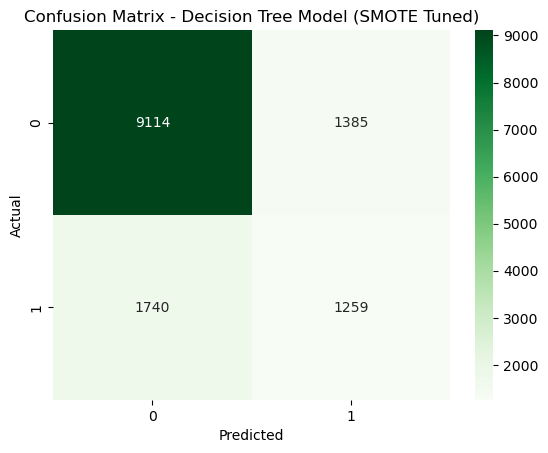

Accuracy Score:  0.7684842198844273
Precision Score:  0.47617246596066565
Recall Score:  0.41980660220073357
F1 Score:  0.4462165514797094
Specificity Score:  0.8680826745404324


In [ ]:
# Define string labels for display
target_names = ['0', '1'] 

# Generate predictions
lr_tuned_pred_smote = dt_best_model_smote.predict(X_smote_test)

# Classification report
print("\nDecision Tree (SMOTE Tuned):")
print(classification_report(y_test, lr_tuned_pred_smote, target_names=target_names))

# Confusion matrix
cm_lr_tuned_smote = confusion_matrix(y_test, lr_tuned_pred_smote, labels=[0, 1])
sns.heatmap(cm_lr_tuned_smote, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree Model (SMOTE Tuned)')
plt.show()

# Model Scores
print('Accuracy Score: ', accuracy_score(y_test, lr_tuned_pred_smote))
print('Precision Score: ', precision_score(y_test, lr_tuned_pred_smote))
print('Recall Score: ', recall_score(y_test, lr_tuned_pred_smote))
print('F1 Score: ', f1_score(y_test, lr_tuned_pred_smote))

tn_bm_smote = cm_lr_tuned_smote[0,0]
fp_bm_smote = cm_lr_tuned_smote[0,1]
specificity_bm_smote = tn_bm_smote/(tn_bm_smote+fp_bm_smote)
print('Specificity Score: ', specificity_bm_smote)

The SMOTE Tuned Decision Tree model shows a moderate improvement in balancing the performance between the two classes compared to both the untuned and non-SMOTE versions. For the majority class (Rejected), the model maintains strong performance with a precision of 0.84, recall of 0.87, and F1-score of 0.85. For the minority class (Approved), the precision improves to 0.48, and recall reaches 0.42, with an F1-score of 0.45 — higher than the original tuned model (F1 = 0.43) and slightly below the SMOTE-only model (F1 = 0.49). Overall accuracy is 77%, which is a middle ground between the higher accuracy of the tuned non-SMOTE model (81%) and the lower accuracy of the SMOTE-only version (74%). The macro average F1-score of 0.65 and the weighted average F1 of 0.76 reflect a more balanced performance across both classes. This suggests that applying both SMOTE and hyperparameter tuning helps reduce class imbalance effects, offering a better trade-off between precision and recall for the minority class, while preserving respectable accuracy and majority class performance.

<h3> Learning Curve </h3>


--- Learning Curve ---


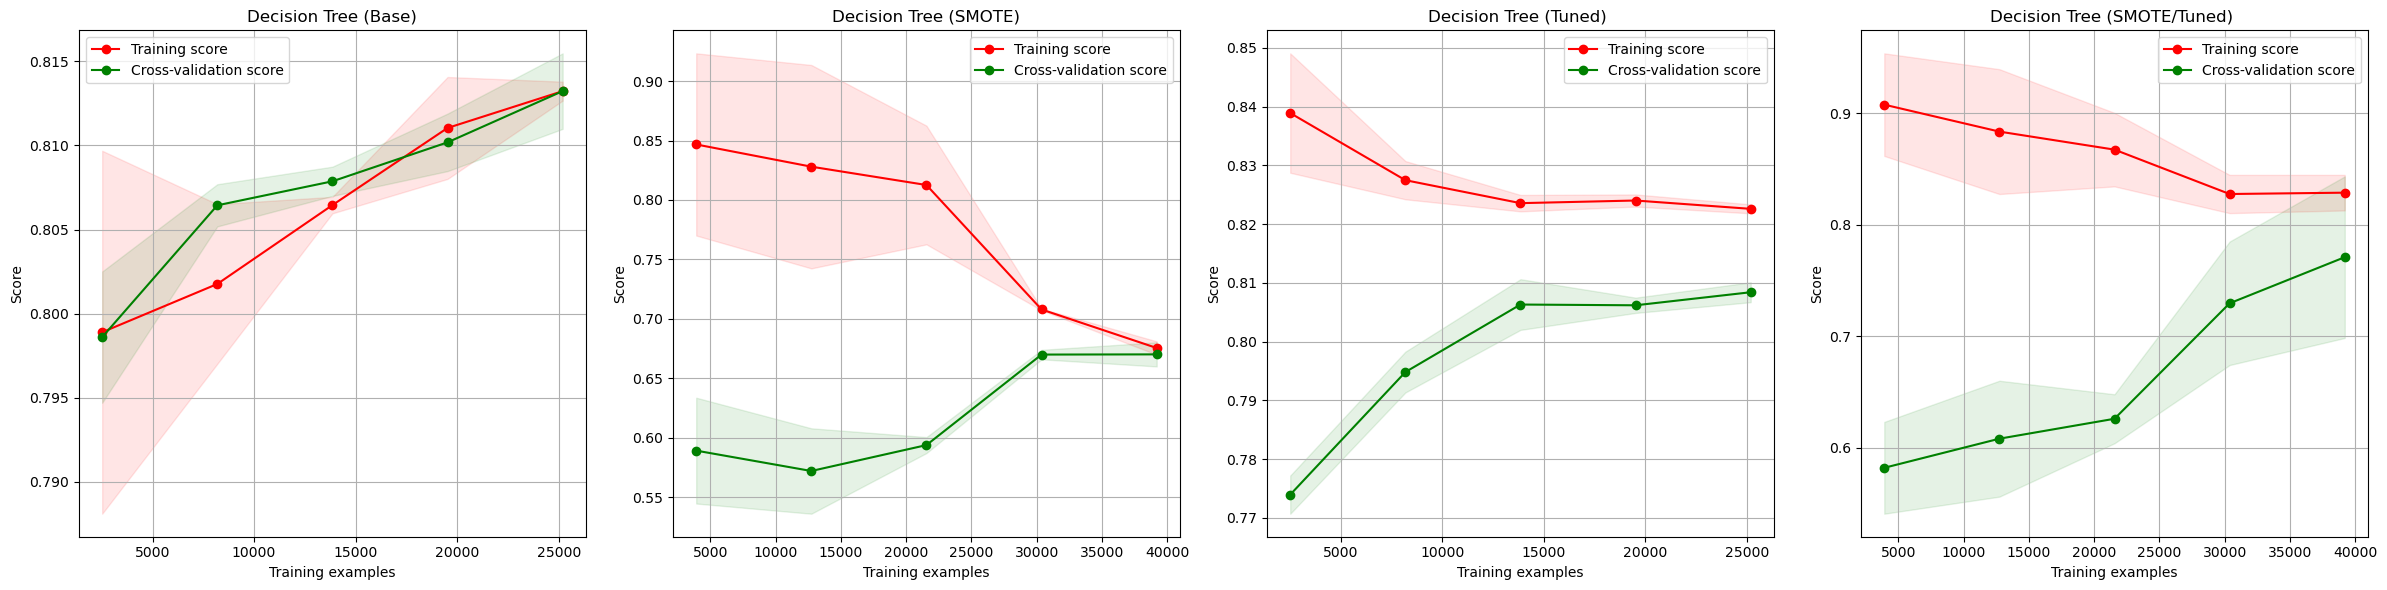

In [38]:
# --- Learning Curve ---

print("\n--- Learning Curve ---")

def plot_learning_curve(estimator, title, X, y, axes=None, train_sizes=np.linspace(0.1, 1.0, 5), cv=None, scoring='accuracy'):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.grid()
    axes.legend(loc="best")
    return plt

# Plot learning curves for different models
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
# Original
plot_learning_curve(DecisionTreeClassifier(max_depth=3, random_state=42),
                    "Decision Tree (Base)",  
                    X_train_scaled, y_train, axes=axes[0], cv=5)

# SMOTE
plot_learning_curve(DecisionTreeClassifier(max_depth=3, random_state=42),
                    "Decision Tree (SMOTE)", 
                    X_smote_train, y_smote_train, axes=axes[1], cv=5)

# Tuned model
plot_learning_curve(dt_best_model, 
                    "Decision Tree (Tuned) ", 
                    X_train_scaled, y_train, axes=axes[2], cv=5)

# SMOTE Tuned model
plot_learning_curve(dt_best_model_smote, 
                    "Decision Tree (SMOTE/Tuned) ", 
                    X_smote_train, y_smote_train, axes=axes[3], cv=5)

plt.tight_layout()
plt.show()



The four learning curves illustrate how the decision tree models perform under different conditions. The base decision tree shows stable but moderate performance, with training and validation scores closely tracking each other around 0.81, suggesting low variance but some underfitting. Applying SMOTE without tuning causes significant overfitting — the training score remains high while the cross-validation score is much lower, and the gap between them remains large even as more data is added. Tuning the decision tree without SMOTE improves both scores slightly but introduces a modest gap, indicating mild overfitting with better generalization. Finally, the SMOTE/tuned model initially shows a wide gap between training and validation scores, but as training examples increase, the gap narrows significantly, and validation performance improves to around 0.75–0.76. The SMOTE with tuning approach yields the best results overall. Although some overfitting remains, it generalizes better than the other models, especially as the training size grows, suggesting that it would perform best on unseen data when given enough examples.